In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
#wqad

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

# Heart Disease

# **Research Question:** How do a person’s health factors influence the likelihood of that person having a heart disease? 

# Introduction

Heart disease is a broad term for many heart conditions. A person can go undiagnosed for most of their life until they experience a major symptom such as a heart attack or even heart failure. Many personal health factors can affect their risk of having a heart disease. This includes, cholesterol, age, and sex.  
For this analysis, we will be using the UCI Machine Learning Repository's Heart Disease dataset. This dataset includes 14 variables, including age, sex, chest pain type, resting blood pressure, cholesterol level, fasting blood sugar, resting ekg results. When analyzing this data, maximum heart rate achieved, exercise induced angina, it is intended to find what health factors can affect a person’s chance of having heart disease. 


Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_double(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)



age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,pred
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,1
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,1,1,110,264,0,0,132,0,1.2,2,0,7,1
57,1,4,130,131,0,0,115,1,1.2,2,1,7,2
57,0,2,130,236,0,2,174,0,0.0,2,1,3,1


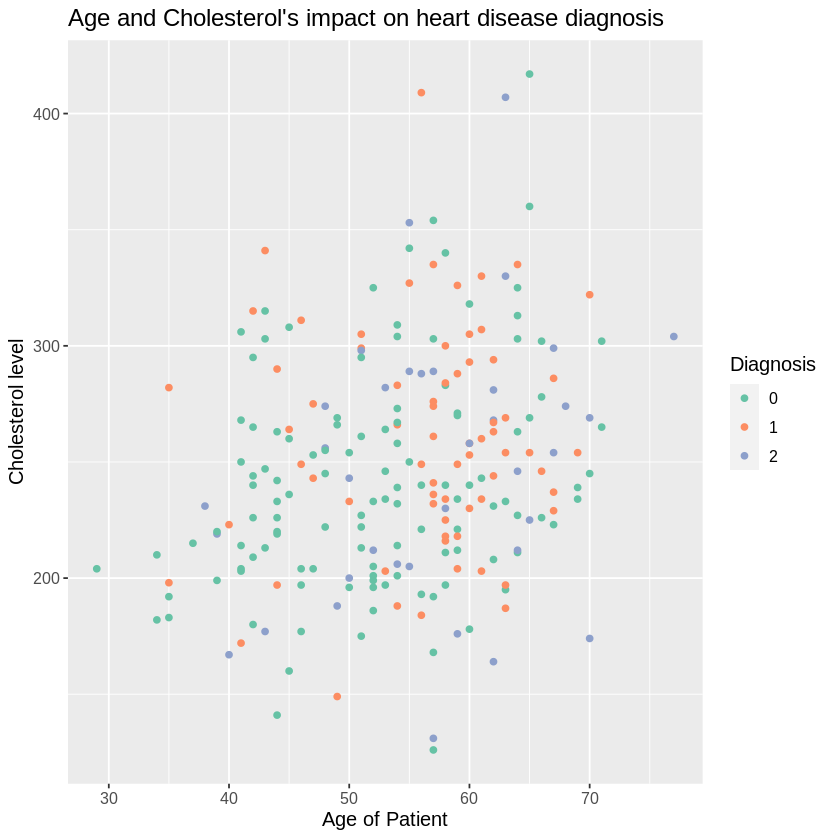

In [3]:
#read and tidy the data
set.seed(100)
heart_disease <- read_csv("heart_disease.data", col_names=FALSE) %>%
    rename(age = X1,
            sex = X2,
          cp = X3,
          trestbps = X4,
          chol = X5,
          fbs = X6,
          restecg =X7,
          thalach = X8,
          exang =X9, 
          oldpeak =X10,
          slope =X11,
          ca = X12,
          thal = X13,
          num = X14) %>%
    mutate(num = as_factor(num))

#splitting data into training and testing dataset
heart_disease_split <- initial_split(heart_disease, prop = 0.75, strata = num)
disease_train <- training(heart_disease_split)
disease_test <- testing(heart_disease_split)

#grouping the num column for visualization clarity
disease_num_train <- mutate(disease_train, pred = ifelse(num == 1 | num == 2, 1, ifelse(num == 3 | num == 4, 2, 0))) %>%
               select(-num) %>%
                filter(ca != "?") %>%
                filter(thal != "?") %>%
                     mutate(pred = as_factor(pred)) %>%
                     mutate(ca = as.numeric(ca))%>%
                     mutate(thal = as.numeric(thal))

disease_num_test <- mutate(disease_test, pred = ifelse(num == 1 | num == 2, 1, ifelse(num == 3 | num == 4, 2, 0))) %>%
               select(-num) %>%
                filter(ca != "?") %>%
                filter(thal != "?") %>%
                     mutate(pred = as_factor(pred)) %>%
                     mutate(ca = as.numeric(ca))%>%
                     mutate(thal = as.numeric(thal))

#creating the scattered plot
heart_disease_plot<-ggplot(disease_num_train, aes(x = age, y = chol, color = as_factor(pred))) +
geom_point() +
labs(x = "Age of Patient",
y = "Cholesterol level",
color = "Diagnosis") +
theme(text = element_text(size = 12)) +
ggtitle("Age and Cholesterol's impact on heart disease diagnosis")+
scale_color_brewer(palette = "Set2")



disease_num_train
heart_disease_plot
#123

In [6]:
set.seed(100022)
#creating a new tibble for foward loops analysis
disease_subset <- disease_num_train %>% 
  select(age, 
         sex, 
         cp, 
         trestbps, 
         chol, 
         fbs, 
         restecg,
         thalach,
         exang,
         oldpeak,
         slope,
         ca,
         thal,
         pred)

names <- colnames(disease_subset %>% select(-pred)) 

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

# create a 5-fold cross-validation object
disease_vfold <- vfold_cv(disease_subset, v = 5, strata = pred)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("pred", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        disease_recipe <- recipe(as.formula(model_string), 
                                data = disease_subset) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(disease_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = disease_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>% 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,pred ~ cp,0.6444752
2,pred ~ cp+oldpeak,0.6929820
3,pred ~ cp+oldpeak+thal,0.6934651
⋮,⋮,⋮
11,pred ~ cp+oldpeak+thal+slope+ca+exang+chol+trestbps+fbs+thalach+sex,0.7244884
12,pred ~ cp+oldpeak+thal+slope+ca+exang+chol+trestbps+fbs+thalach+sex+age,0.7201449
13,pred ~ cp+oldpeak+thal+slope+ca+exang+chol+trestbps+fbs+thalach+sex+age+restecg,0.7151076


In [19]:
max1 <- arrange(accuracies, accuracy)
max1

size,model_string,accuracy
<int>,<chr>,<dbl>
1,pred ~ cp,0.6444752
2,pred ~ cp+oldpeak,0.6929820
3,pred ~ cp+oldpeak+thal,0.6934651
⋮,⋮,⋮
7,pred ~ cp+oldpeak+thal+slope+ca+exang+chol,0.7466140
9,pred ~ cp+oldpeak+thal+slope+ca+exang+chol+trestbps+fbs,0.7466184
10,pred ~ cp+oldpeak+thal+slope+ca+exang+chol+trestbps+fbs+thalach,0.7509662


In [5]:
set.seed(100022)
#find k
disease_best_recipe <- recipe(pred~cp+oldpeak+thal+slope+ca+exang+chol+trestbps+fbs+thalach, 
                                data = disease_num_train) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())

disease_vfold_1 <- vfold_cv(disease_num_train, v = 5, strata = pred) 

k_vals <- tibble(neighbors = seq(from = 1, to = 40))

knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

knn_fit <- workflow() %>%
  add_recipe(disease_best_recipe) %>%
  add_model(knn_spec) %>%
  tune_grid(resamples = disease_vfold_1, grid = k_vals) %>%
  collect_metrics() %>%
  filter(.metric == "accuracy") %>%
  select(neighbors, mean) %>%
  arrange(mean)

knn_fit

neighbors,mean
<int>,<dbl>
1,0.5958674
2,0.5958674
3,0.6629337
⋮,⋮
10,0.7109486
5,0.7157795
9,0.7199341


In [13]:
#final calculation

disease_best_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = 9) %>%
     set_engine("kknn") %>%
     set_mode("classification")


knn_fit <- workflow() %>%
  add_recipe(disease_best_recipe) %>%
  add_model(disease_best_spec) %>%
  fit(data = disease_num_train)

disease_predict <- predict(knn_fit, disease_num_test) %>%
    bind_cols(disease_num_test) %>%
    metrics(truth = pred, estimate = .pred_class) %>%
    filter(.metric == "accuracy") %>%
    select(.estimate) %>%
    pull()
disease_predict

[1] 0.625

# Methods

The main columns that will be used are age, sex, blood pressure, and cholesterol level. They will be compared to the other factors to see which ones lead to the most accurate predictions of heart disease. These comparisons will be carried out using 

We decided to create groupings of the num or predicted attributes. There were five categories originally and we combined them to create three. The first was a not at risk group which consisted of the zero category. We combined the level one and two categories to create a moderately at risk group, and the three and four levels to create an at high risk group. The not at risk group would have no risk of heart disease and would not require treatment. The moderately at risk group would have a risk of heart disease, but would not require as agressive of treatment. The highly at risk group would have a risk of heart disease and would require extensive treatment. 


# Expected Outcomes and Significance

We expect that age, sex, blood pressure, and cholesterol level will be significant predictors of heart disease. We expect that there will be a positive relationship between these predictors and occurence rate of heart disease. 

Predicting which factors raise a person's likelihood for heart disease allows medical professionals to be more accurately informed and increases the chance for accurate diagnosis. As heart disease is one of the leading causes of death, early preventative and diagnostic action can lead to a decreased mortality rate.

Finally, a more accurate diagnosis of heart disease allows for more detailed research of its causes, as well as potential treatments. By prioritizing focus on those causes that play a more significant role, future research in the field may become more efficient and effective.